In [1]:
import tensorflow as tf
from core.model import ModelMNIST10x10_base

class Implement(ModelMNIST10x10_base):
    def __init__(self, batch_size=128, opt=tf.train.MomentumOptimizer(0.1, 0.9, use_nesterov=True)):
        super(Implement, self).__init__(batch_size, opt)

    def compute_gradient(self, cost, var_refs):
        grads = tf.gradients(
                cost, var_refs,
                grad_ys=None, aggregation_method=None, colocate_gradients_with_ops=True)
        
        for l, g in zip(range(len(grads)), grads):
            delta = g
            tf.summary.histogram('update/gradient/{}'.format(l), g)
            tf.summary.histogram('update/delta/{}'.format(l), delta)
            
        return grads

/Users/clint/virtualenv/tf/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
import sys
import logging
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s', stream=sys.stdout)

from core.utils import loop
model = Implement(batch_size=128)
history = loop(model, 30, './summary/5_1_first_order_optimization')

[1124 13:33:48 @fs.py:89] WRN Env var $TENSORPACK_DATASET not set, using /Users/clint/tensorpack_data for datasets.
[1124 13:33:48 @prefetch.py:169] [PrefetchData] Will fork a dataflow more than one times. This assumes the datapoints are i.i.d.
[INFO] session initialized
[INFO] [0000] [train] cost:0.185 accuracy:0.628 elapsed:3.662sec [valid] cost:0.084 accuracy:0.870 elapsed:0.234sec
[INFO] [0001] [train] cost:0.073 accuracy:0.891 elapsed:3.737sec [valid] cost:0.059 accuracy:0.913 elapsed:0.191sec
[INFO] [0002] [train] cost:0.058 accuracy:0.917 elapsed:3.466sec [valid] cost:0.051 accuracy:0.930 elapsed:0.208sec


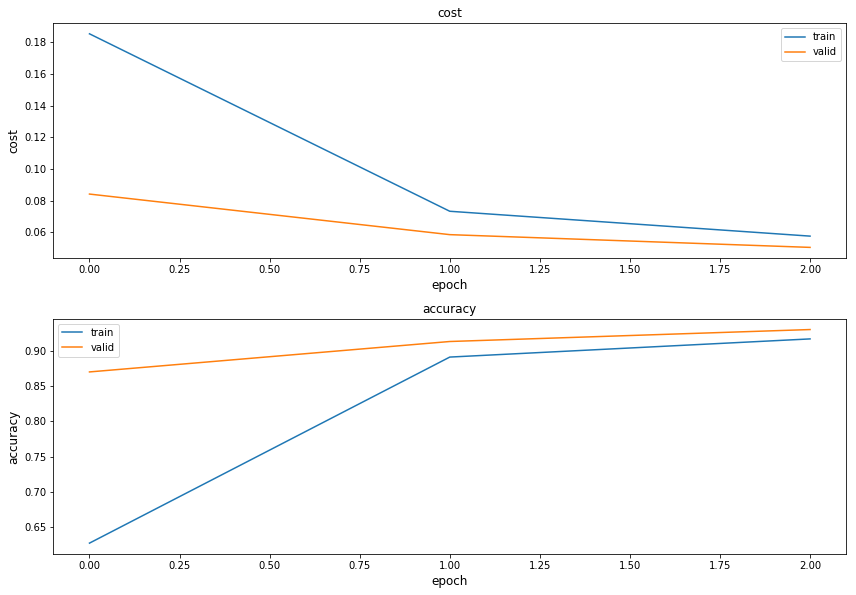

In [4]:
import matplotlib
%matplotlib inline

from core.utils import plot_jupyter
plot_jupyter(history)